<a href="https://colab.research.google.com/github/footprinthere/DeepLearningWithTensorflow/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier (with fashion MNIST dataset)

### Modules

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pprint import pprint
import matplotlib.pyplot as plt

### Dataset

keras에서 fashion mnist 데이터셋을 불러온다.

In [2]:
# load data
(train_x, train_y), (test_x, test_y) = keras.datasets.fashion_mnist.load_data()
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}
num_classes = 10

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


일부 데이터를 plt를 통해 시각화해 본다.

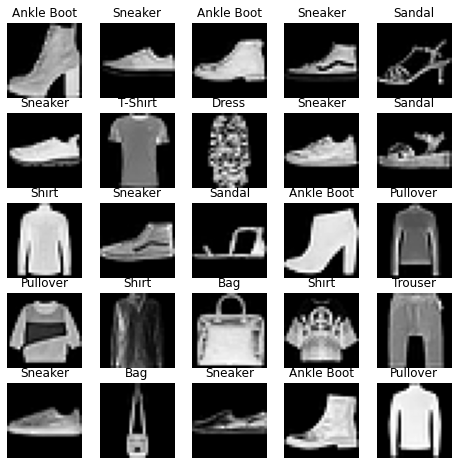

In [3]:
fig = plt.figure(figsize=(8, 8))

rows = 5
columns = 5
for i in range(1, rows*columns+1):
    idx = np.random.randint(len(train_x))
    img = train_x[idx]
    label = labels_map[train_y[idx]]

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis(False)
plt.show()

전처리를 수행한다.

In [4]:
# preprocessing
def preprocess(data):
    # normalization
    result = data.astype(np.float32) / 255.0
    # add channel dimension at the end
    result = np.expand_dims(result, axis=-1)
    return result

train_x = preprocess(train_x)
test_x = preprocess(test_x)
train_y = train_y.astype(np.int64)
test_y = test_y.astype(np.int64)

print(train_x.shape)

(60000, 28, 28, 1)


tf.data.Dataset으로 학습에 사용할 데이터셋을 구성한다.

In [5]:
buffer_size = 100000
batch_size = 200

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).\
    shuffle(buffer_size).prefetch(batch_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).\
    prefetch(batch_size).batch(batch_size)

print(train_dataset)
print(test_dataset)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


### Model

학습에 사용할 CNN 모델을 구현한다. 구현할 모델의 구조는 다음과 같다.  
  
  
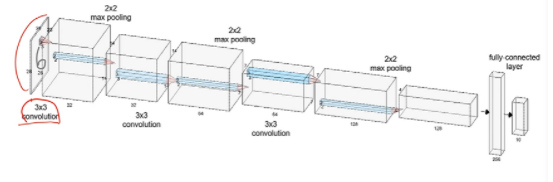

In [6]:
# create model
model = keras.Sequential()

def conv(filters):
    return layers.Conv2D(filters, kernel_size=3, padding='same', activation=tf.nn.relu)
def max_pool():
    return layers.MaxPool2D(pool_size=(2,2), padding='same')

model.add(layers.Conv2D(
    filters=32, kernel_size=3, padding='same', activation=tf.nn.relu,
    input_shape=(28, 28, 1)
))
model.add(max_pool())

model.add(conv(64))
model.add(max_pool())
model.add(conv(128))
model.add(max_pool())

model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation=tf.nn.relu))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

최적화에 사용할 loss function을 정의한다.

In [7]:
# define loss function
def loss_func(model, x, y):
    logits = model(x, training=True)
    return tf.reduce_mean(keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=logits, from_logits=True
    ))

gradients와 loss를 반환하는 함수를 정의한다.

In [8]:
# define gradient function
def grad_func(model, x, y):
    with tf.GradientTape() as tape:
        loss = loss_func(model, x, y)
    return tape.gradient(loss, model.variables), loss

### Training

학습에 사용할 optimizer를 생성한다.

In [9]:
# create optimizer
lr = 0.01
epochs = 15
opt = keras.optimizers.Adam(learning_rate=lr)

평가를 위해 accuracy를 계산하는 함수를 정의한다.

In [10]:
# define function for evaluation
def evaluate(model, x, y):
    logits = model(x, training=False)
    correct = tf.equal(tf.argmax(logits, -1), y)
    return tf.reduce_mean(tf.cast(correct, np.float32))

구현한 모델을 바탕으로 학습을 수행한다.

In [47]:
# training
print("Learning started.")
loss_hist = []
acc_hist = []
test_acc_hist = []

for epoch in range(1, epochs+1):
    # training step
    avg_loss = 0
    avg_acc = 0
    step = 0

    for x, y in train_dataset:
        grads, loss = grad_func(model, x, y)
        opt.apply_gradients(zip(grads, model.variables))
        avg_loss += loss
        avg_acc += evaluate(model, x, y)
        step += 1
        print(".", end='')
    print()
    
    avg_loss /= step
    avg_acc /= step
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # test step
    avg_test_acc = 0
    step = 0

    for x, y in test_dataset:
        avg_test_acc += evaluate(model, x, y)
        step += 1
        print(".", end='')
    print()
    
    avg_test_acc /= step
    test_acc_hist.append(avg_test_acc)

    print("{:3} | loss {:.4f} | train acc {:.4f} | test acc {:.4f}".\
          format(epoch, avg_loss, avg_acc, avg_test_acc))
    
print("Learning finished.")

Learning started.
............................................................................................................................................................................................................................................................................................................
..................................................
  1 | loss 0.4426 | train acc 0.8557 | test acc 0.8670
............................................................................................................................................................................................................................................................................................................
..................................................
  2 | loss 0.3597 | train acc 0.8848 | test acc 0.8613
........................................................................................................................................................................

loss와 accuracy의 변화를 시각화해 본다.

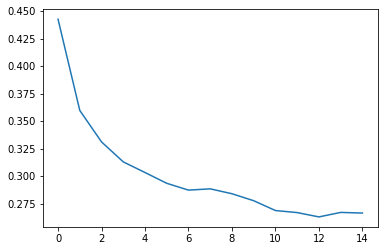

In [48]:
# plot training loss
plt.plot(loss_hist)

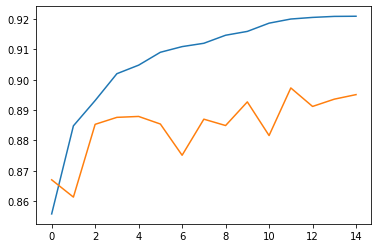

In [49]:
# plot training and test accuracy
plt.plot(acc_hist)
plt.plot(test_acc_hist)